# Step 1:  Light curve simulation


## Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle, SkyOffsetFrame
from astropy.time import Time
from regions import CircleSkyRegion

import logging

log = logging.getLogger(__name__)

And some gammapy specific imports

In [3]:
from gammapy.data import Observation
from gammapy.irf import load_cta_irfs
from gammapy.datasets import SpectrumDataset, Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpDecayTemporalModel,
    PointSpatialModel,
    SkyModel,
    Models,
)
from gammapy.maps import MapAxis
from gammapy.estimators import LightCurveEstimator
from gammapy.makers import SpectrumDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import LightCurveTemplateTemporalModel

## Simulating a light curve

We will simulate 10 datasets using an `PowerLawSpectralModel` and a `ExpDecayTemporalModel`. The important thing to note here is how to attach a different `GTI` to each dataset.

In [5]:
# Loading IRFs
irfs = load_cta_irfs("/Users/sonal/PostDocWork/SummerStudent_Helena/Prod5-North-20deg-AverageAz-4LSTs09MSTs.18000s-v0.1.fits")

In [6]:
# Reconstructed and true energy axis

#center = SkyCoord(0.0, 0.0, unit="deg", frame="galactic")
center = SkyCoord(135.67, 01.086, unit="deg", frame="galactic")  #LS I +61° 303

energy_axis = MapAxis.from_edges(
    np.logspace(-0.5, 1.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy_true", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=center, radius=on_region_radius)

In [7]:
# Pointing position
pointing = SkyCoord(135.67+0.5, 01.086+0.5, unit="deg", frame="galactic")


Note that observations are usually conducted in  Wobble mode, in which the source is not in the center of the camera. This allows to have a symmetrical sky position from which background can be estimated.

In [8]:
# Define the source model: A combination of spectral and temporal model

#gti_t0 = Time('2020-05-31T12:00:00.000')  #PKSB1222+216
gti_t0 = Time("2021-01-01") #Ours
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)


temporal_model = LightCurveTemplateTemporalModel.read('TemporalProfile_Sinusoidal_Period30d.fits')

model_simu = SkyModel(
    spectral_model=spectral_model,
    #spatial_model=point_model,
    temporal_model=temporal_model,
    name="model-simu",
)

print(temporal_model)

LightCurveTemplateTemporalModel model summary:
Start time: 59215.0 MJD
End time: 59364.69696969697 MJD
Norm min: 6.293616306246586e-05
Norm max: 0.9999370638369376



In [9]:
# Look at the model
model_simu.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,int64
index,3.0000e+00,,nan,nan,False,0.000e+00
amplitude,1.0000e-11,cm-2 s-1 TeV-1,nan,nan,False,0.000e+00
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


Now, define the start and observation livetime wrt to the reference time, `gti_t0`

In [12]:
n_obs = 30

tstart = np.linspace(0,60,30) * u.d
lvtm = np.zeros(n_obs)
lvtm.fill(60)
lvtm = lvtm * u.min


Now perform the simulations

In [13]:
datasets = Datasets()


empty = SpectrumDataset.create(
    e_reco=energy_axis, e_true=energy_axis_true, region=on_region, name="empty"
)

maker = SpectrumDatasetMaker(selection=["exposure", "background", "edisp"])

for i in range(n_obs):
    obs = Observation.create(
        pointing=pointing,
        livetime=lvtm[i],
        tstart=tstart[i],
        irfs=irfs,
        reference_time=gti_t0,
        obs_id=i,
    )
    #print(obs)
    empty_i = empty.copy(name=f"dataset_{i}")
    #maker = SpectrumDatasetMaker(selection=["aeff", "background", "edisp"])
    dataset = maker.run(empty_i, obs)
    dataset.models = model_simu
    dataset.fake()
    datasets.append(dataset)

The reduced datasets have been successfully simulated. Let's take a quick look into our datasets.

In [14]:
datasets.info_table()

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str10,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
dataset_0,357,18.341005418072154,338.65899458192786,37.9770971580763,353.92934755297483,18.341005418072154,335.5883421349027,342326351.5317853,3391149743.6206517,3600.0000000000005,3600.0000000000005,0.09916666666666665,0.0050947237272422645,0.09407194293942439,9,9,cash,-2377.0403909468746
dataset_1,471,18.341005418072005,452.65899458192797,46.39126132832486,494.03877302062284,18.341005418072005,475.6977676025508,342326351.5317825,3391149743.6206236,3599.999999999971,3599.999999999971,0.13083333333333438,0.0050947237272422645,0.12573860960609212,9,9,cash,-3425.729233530545
dataset_2,680,18.34100541807215,661.6589945819278,59.9191020199358,607.9123476346858,18.34100541807215,589.5713422166135,342326351.53178525,3391149743.6206512,3600.0,3600.0,0.18888888888888888,0.005094723727242264,0.18379416516164662,9,9,cash,-5391.476155120445
dataset_3,678,18.34100541807215,659.6589945819278,59.79843527180916,674.5566413599513,18.34100541807215,656.2156359418792,342326351.53178525,3391149743.6206512,3600.0,3600.0,0.18833333333333332,0.005094723727242264,0.18323860960609106,9,9,cash,-5346.430174620668
dataset_4,662,18.341005418071557,643.6589945819285,58.827826678658326,681.6866569416806,18.341005418071557,663.3456515236089,342326351.5317742,3391149743.6205416,3599.9999999998836,3599.9999999998836,0.18388888888889485,0.005094723727242264,0.17879416516165259,9,9,cash,-5243.461791986674
dataset_5,625,18.34100541807215,606.6589945819278,56.54597655922115,627.9839933738155,18.34100541807215,609.6429879557433,342326351.53178525,3391149743.6206512,3600.0,3600.0,0.1736111111111111,0.005094723727242264,0.16851638738386884,9,9,cash,-4916.001672202454
dataset_6,543,18.34100541807215,524.6589945819278,51.283695920628524,523.337474545119,18.34100541807215,504.9964691270468,342326351.53178525,3391149743.6206512,3600.0,3600.0,0.15083333333333335,0.005094723727242264,0.14573860960609106,9,9,cash,-4058.8142465325213
dataset_7,389,18.34100541807215,370.65899458192786,40.435583034876075,387.02201587404903,18.34100541807215,368.68101045597695,342326351.53178525,3391149743.6206512,3600.0,3600.0,0.10805555555555556,0.005094723727242264,0.1029608318283133,9,9,cash,-2662.2532310035704


In [15]:
datasets.info_table().keys()

['name',
 'counts',
 'background',
 'excess',
 'sqrt_ts',
 'npred',
 'npred_background',
 'npred_signal',
 'exposure_min',
 'exposure_max',
 'livetime',
 'ontime',
 'counts_rate',
 'background_rate',
 'excess_rate',
 'n_bins',
 'n_fit_bins',
 'stat_type',
 'stat_sum']

336.85899458192813


Text(0, 0.5, 'Excess counts')

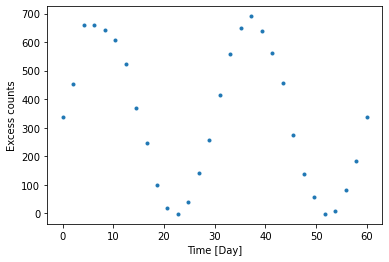

In [16]:
data_table = datasets.info_table()
y=data_table['excess']
print(np.mean(y))
plt.plot(tstart, data_table['excess'],'.')
plt.xlabel('Time [Day]')
plt.ylabel('Excess counts')

Now you have your simulated light curve!
You can use your fitting tool for fitting and check how well we could regenrate the injected temporal profile.